In [467]:
# Run reviews_exploratiion.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno

In [468]:
# Prevent printing scientific notation for latex tables.
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [469]:
# Load the reviews data.
games_reviews_long_df = pd.read_csv('games_reviews_flat.csv')
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,topCriticScore,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id
0,2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,80.52874,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009
1,4,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,80.73684,83.00000,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26,True,False,JP3164630000
2,6,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,80.73684,83.00000,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,pub1_stock_id,26,False,True,JP3164630000
3,10,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,Mirror's Edge Catalyst,Mirror's Edge Catalyst,...,70.16883,44.00000,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,pub1_stock_id,1,False,True,16721
4,14,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,MLB The Show 16,MLB 16: The Show,...,85.46429,95.00000,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z,pub1_stock_id,13634,False,True,JP3435000009


In [470]:
games_reviews_long_df.columns

Index(['Unnamed: 0', 'igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate',
       'variable', 'igdb_company_id', 'developer', 'publisher', 'stock_id'],
      dtype='object')

In [471]:
# stock_id is object and needs to be parsed as a string.
games_reviews_long_df['stock_id'] = games_reviews_long_df['stock_id'].astype('string')

In [472]:
# Parse first release date as datetime.
games_reviews_long_df['first_release_date'] = pd.to_datetime(games_reviews_long_df['first_release_date'],unit='s')

In [473]:
# Create date column from first_release_date for joining
games_reviews_long_df['date'] = games_reviews_long_df['first_release_date']

# # Parse first release date as datetime.
# games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'],unit='s', format='%Y-%m-%d')
games_reviews_long_df.dtypes

Unnamed: 0                      int64
igdb_id                         int64
first_release_date     datetime64[ns]
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [474]:
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-06
1,4,359,2016-11-29,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,83.00000,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26,True,False,JP3164630000,2016-11-29
2,6,359,2016-11-29,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,83.00000,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,pub1_stock_id,26,False,True,JP3164630000,2016-11-29
3,10,2112,2016-06-07,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,Mirror's Edge Catalyst,Mirror's Edge Catalyst,...,44.00000,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,pub1_stock_id,1,False,True,16721,2016-06-07
4,14,2212,2016-03-29,MLB The Show 16,mlb-the-show-16,False,True,False,MLB The Show 16,MLB 16: The Show,...,95.00000,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z,pub1_stock_id,13634,False,True,JP3435000009,2016-03-29


In [475]:
# Load the financial data.
stock_ff_index_df = pd.read_csv('financial_data_clean.csv')
stock_ff_index_df.head()

,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,total_return_factor,stock_id,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,1.00839,FR0000054470,...,-0.29000,0.52000,0.24000,-0.11000,0.22000,0.00000,308.80000,NaN,NaN,NaN
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,1.00839,FR0000054470,...,0.93000,-0.36000,0.14000,-0.25000,0.22000,0.00000,310.56000,-0.01439,0.00570,-0.02009
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,1.00839,FR0000054470,...,2.37000,-1.31000,0.43000,-0.20000,0.06000,0.00000,319.53000,0.01102,0.02888,-0.01787
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,1.00839,FR0000054470,...,1.33000,-0.10000,0.66000,0.04000,0.05000,0.00000,321.06000,0.08417,0.00479,0.07938
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,1.00839,FR0000054470,...,-0.07000,0.07000,1.52000,-0.54000,0.56000,0.00000,319.89000,0.01106,-0.00364,0.01470


In [476]:
stock_ff_index_df.columns

Index(['Unnamed: 0', 'gvkey', 'iid', 'date', 'company_name',
       'shares_outstanding', 'trading_volume', 'closing_price',
       'total_return_factor', 'stock_id', 'eu', 'jp', 'us', 'mkt-rf', 'smb',
       'hml', 'rmw', 'cma', 'rf', 'benchmark_price', 'returns',
       'benchmark_returns', 'excess_return'],
      dtype='object')

In [477]:
# stock_id is object and needs to be parsed as a string.
stock_ff_index_df['stock_id'] = stock_ff_index_df['stock_id'].astype('string')

In [478]:
# Convert stock_data_df date column to datetime.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
stock_ff_index_df.dtypes

Unnamed: 0                      int64
gvkey                           int64
iid                            object
date                   datetime64[ns]
company_name                   object
shares_outstanding            float64
trading_volume                float64
closing_price                 float64
total_return_factor           float64
stock_id               string[python]
eu                               bool
jp                               bool
us                               bool
mkt-rf                        float64
smb                           float64
hml                           float64
rmw                           float64
cma                           float64
rf                            float64
benchmark_price               float64
returns                       float64
benchmark_returns             float64
excess_return                 float64
dtype: object

In [479]:
stock_ff_index_df.head()

,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,total_return_factor,stock_id,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,1.00839,FR0000054470,...,-0.29000,0.52000,0.24000,-0.11000,0.22000,0.00000,308.80000,NaN,NaN,NaN
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,1.00839,FR0000054470,...,0.93000,-0.36000,0.14000,-0.25000,0.22000,0.00000,310.56000,-0.01439,0.00570,-0.02009
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,1.00839,FR0000054470,...,2.37000,-1.31000,0.43000,-0.20000,0.06000,0.00000,319.53000,0.01102,0.02888,-0.01787
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,1.00839,FR0000054470,...,1.33000,-0.10000,0.66000,0.04000,0.05000,0.00000,321.06000,0.08417,0.00479,0.07938
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,1.00839,FR0000054470,...,-0.07000,0.07000,1.52000,-0.54000,0.56000,0.00000,319.89000,0.01106,-0.00364,0.01470


Begin by joining the reviews dataset with the financial dataset on release date and stock_id.

In [480]:
# Convert both dfs date columns to the same type.
# stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
# games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'])
stock_ff_index_df.date = stock_ff_index_df['date'].astype('string')
games_reviews_long_df.date = games_reviews_long_df['date'].astype('string')


In [481]:
games_reviews_long_df.dtypes

Unnamed: 0                      int64
igdb_id                         int64
first_release_date     datetime64[ns]
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [482]:
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-06
1,4,359,2016-11-29,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,83.00000,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26,True,False,JP3164630000,2016-11-29
2,6,359,2016-11-29,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,83.00000,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,pub1_stock_id,26,False,True,JP3164630000,2016-11-29
3,10,2112,2016-06-07,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,Mirror's Edge Catalyst,Mirror's Edge Catalyst,...,44.00000,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,pub1_stock_id,1,False,True,16721,2016-06-07
4,14,2212,2016-03-29,MLB The Show 16,mlb-the-show-16,False,True,False,MLB The Show 16,MLB 16: The Show,...,95.00000,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z,pub1_stock_id,13634,False,True,JP3435000009,2016-03-29


In [483]:
games_reviews_returns_df = pd.merge(games_reviews_long_df, stock_ff_index_df, how='left', on=['date', 'stock_id'])
games_reviews_returns_df.head()

,Unnamed: 0_x,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,0.49000,-0.09000,1.07000,-0.27000,0.14000,0.00000,1394.21000,-0.00773,0.00176,-0.00949
1,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,0.49000,-0.09000,1.07000,-0.27000,0.14000,0.00000,1394.21000,-0.00772,0.00176,-0.00949
2,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,0.49000,-0.09000,1.07000,-0.27000,0.14000,0.00000,1394.21000,0.01166,-0.00398,0.01564
3,4,359,2016-11-29,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,-0.48000,0.02000,0.00000,-0.10000,0.10000,0.00000,1385.95000,-0.00511,-0.00036,-0.00476
4,6,359,2016-11-29,Final Fantasy XV,final-fantasy-xv,False,True,False,Final Fantasy XV,Final Fantasy XV,...,-0.48000,0.02000,0.00000,-0.10000,0.10000,0.00000,1385.95000,-0.00511,-0.00036,-0.00476


In [484]:
games_reviews_returns_df = games_reviews_returns_df.dropna()

<Axes: >

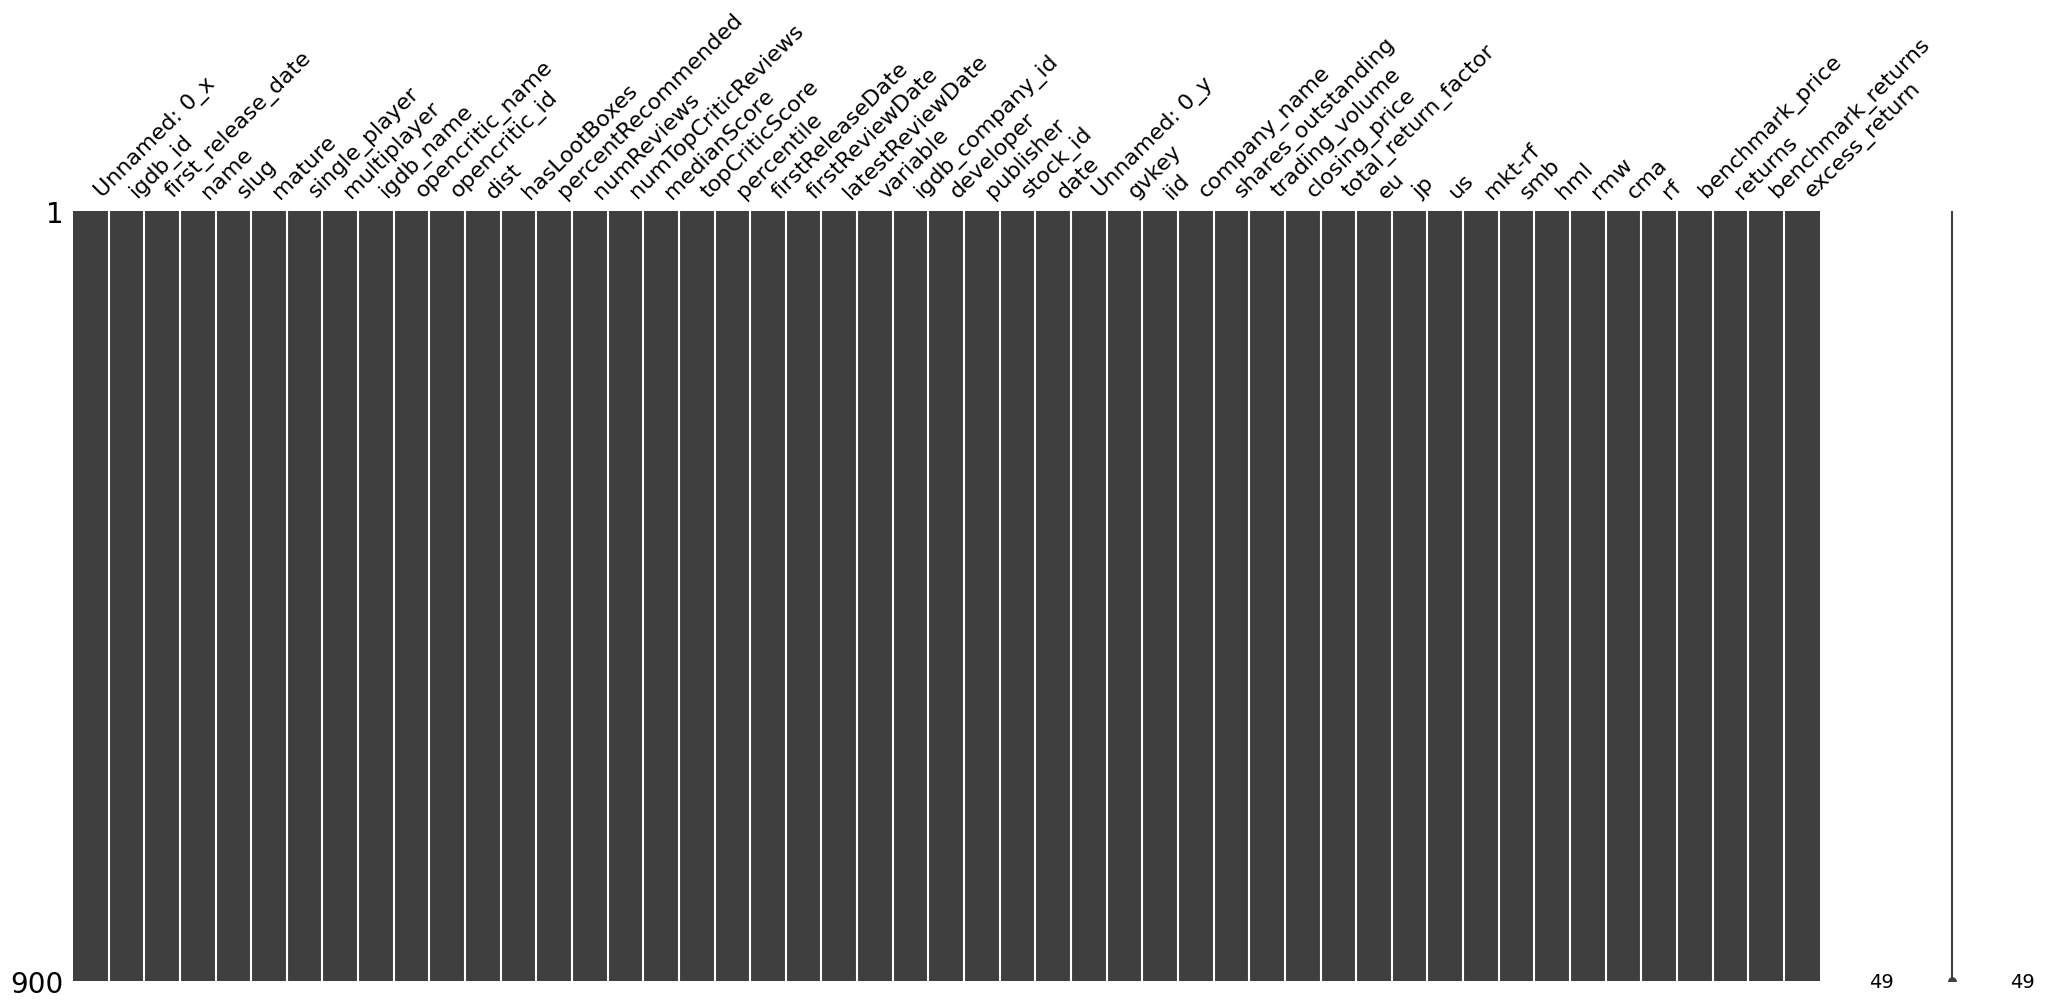

In [485]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_reviews_returns_df)

In [486]:
games_reviews_returns_df.columns

Index(['Unnamed: 0_x', 'igdb_id', 'first_release_date', 'name', 'slug',
       'mature', 'single_player', 'multiplayer', 'igdb_name',
       'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'firstReleaseDate',
       'firstReviewDate', 'latestReviewDate', 'variable', 'igdb_company_id',
       'developer', 'publisher', 'stock_id', 'date', 'Unnamed: 0_y', 'gvkey',
       'iid', 'company_name', 'shares_outstanding', 'trading_volume',
       'closing_price', 'total_return_factor', 'eu', 'jp', 'us', 'mkt-rf',
       'smb', 'hml', 'rmw', 'cma', 'rf', 'benchmark_price', 'returns',
       'benchmark_returns', 'excess_return'],
      dtype='object')

In [487]:
games_reviews_returns_df.describe()[[
    'dist',
    'percentRecommended',
    'numReviews',
    'numTopCriticReviews',
    'medianScore',
    'topCriticScore',
    ]].style.format({'D':'{:0.5f}'},precision=5).to_latex('games_descriptive_stats.tex')

In [488]:
games_reviews_returns_df.describe()[[
    'shares_outstanding',
    'trading_volume',
    'mkt-rf',
    'smb',
    'hml',
    'rmw',
    'cma',
    'rf',
    'returns',
    'benchmark_returns',
    'excess_return'
    ]].style.format({'D':'{:0.5f}'},precision=5).to_latex('companies_descriptive_stats.tex')

In [489]:
# # Drop columns which are no longer needed.
# stock_games_df = stock_games_df.drop([
#     'Unnamed: 0_x',
#     'iid',
#     'pub1_stock_id',
#     'pub2_stock_id'
#     ]
#     , axis=1)